---

This notebook contains code to re-create **Figure 9** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, D. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import pylab as pl
from tqdm import tqdm, tqdm_notebook
from matplotlib.ticker import ScalarFormatter,FuncFormatter

In [2]:
from celerite_base import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

---
### Create data


In [4]:
def make_scenario1(phi_gal, l2):
    
    p0 = 1.0
    alpha = 0.7
    nu0 = 1.4e9
    nu = 3e8/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*phi_gal*l2)
    mu_u = p0*k*np.sin(2.*phi_gal*l2)
    
    return mu_q, mu_u

In [5]:
const_c = 3e8    # speed of light

nu_min = 0.58e9  # minimum frequency
nu_max = 2.50e9  # maximum frequency

nu = np.linspace(nu_min, nu_max, 512)  # make data regularly spaced in frequency:
l2 = (const_c/nu)**2                   # convert frequencies to lambda^2

l2_min = (const_c/nu_max)**2
l2_max = (const_c/nu_min)**2

t1 = np.linspace(l2_min, l2_max, 512)  # make regular sampling in lambda^2

In [6]:
phi_gal = 50.
stokesQ, stokesU = make_scenario1(phi_gal, l2)

---
### Set Noise levels

Following Sun et al (2010), we define the SNR as:

${\rm SNR}_{\rm int} = \sqrt{N_{\rm chan}} \times \frac{P_0}{\sigma_{\nu}}$

where $\sigma_{\nu}$ is the noise on an individual channel. 

In [7]:
p0 = np.mean(np.sqrt(stokesQ**2+stokesU**2))
sig8 = p0*np.sqrt(len(l2))/8
print("Noise required per channel to have an 8 sigma SNR in the integrated image: {:2f}".format(sig8))

noise = np.array([0.2,0.4,0.8,1.6,sig8])

Noise required per channel to have an 8 sigma SNR in the integrated image: 2.904412


---
### Run realisations

In [8]:
def runreal(l2, stokesQ, stokesU,  noise):
    
    mls = []
    exs = []
    upe = []
    dne = []
    for n in noise:
        stokesQn=stokesQ + np.random.normal(loc =0.0, scale=n, size = len(stokesQ))
        stokesUn=stokesU + np.random.normal(loc =0.0, scale=n, size = len(stokesU))

        GP = MyCelerite(n)
        GP.celerite_optimize(l2, stokesQn, stokesUn)
        GP.celerite_predict(stokesQn, stokesUn, t1)
        rm_ml,rm_ex,rm_lo,rm_up = GP.celerite_rmpred()

        mls.append(rm_ml)
        exs.append(rm_ex)
        upe.append(rm_lo)
        dne.append(rm_up)

    asym_errors = [upe,dne]
    
    return mls,exs,asym_errors

First just run one realisation to get the idea:

In [9]:
nreal=1

In [10]:
exps = np.zeros((nreal,noise.shape[0]))  # array to store expectation values for each realisation

for n in tqdm_notebook(range(nreal)):
    mls,exs,asym_errors = runreal(l2, stokesQ, stokesU,  noise)
    exps[n,:] = exs

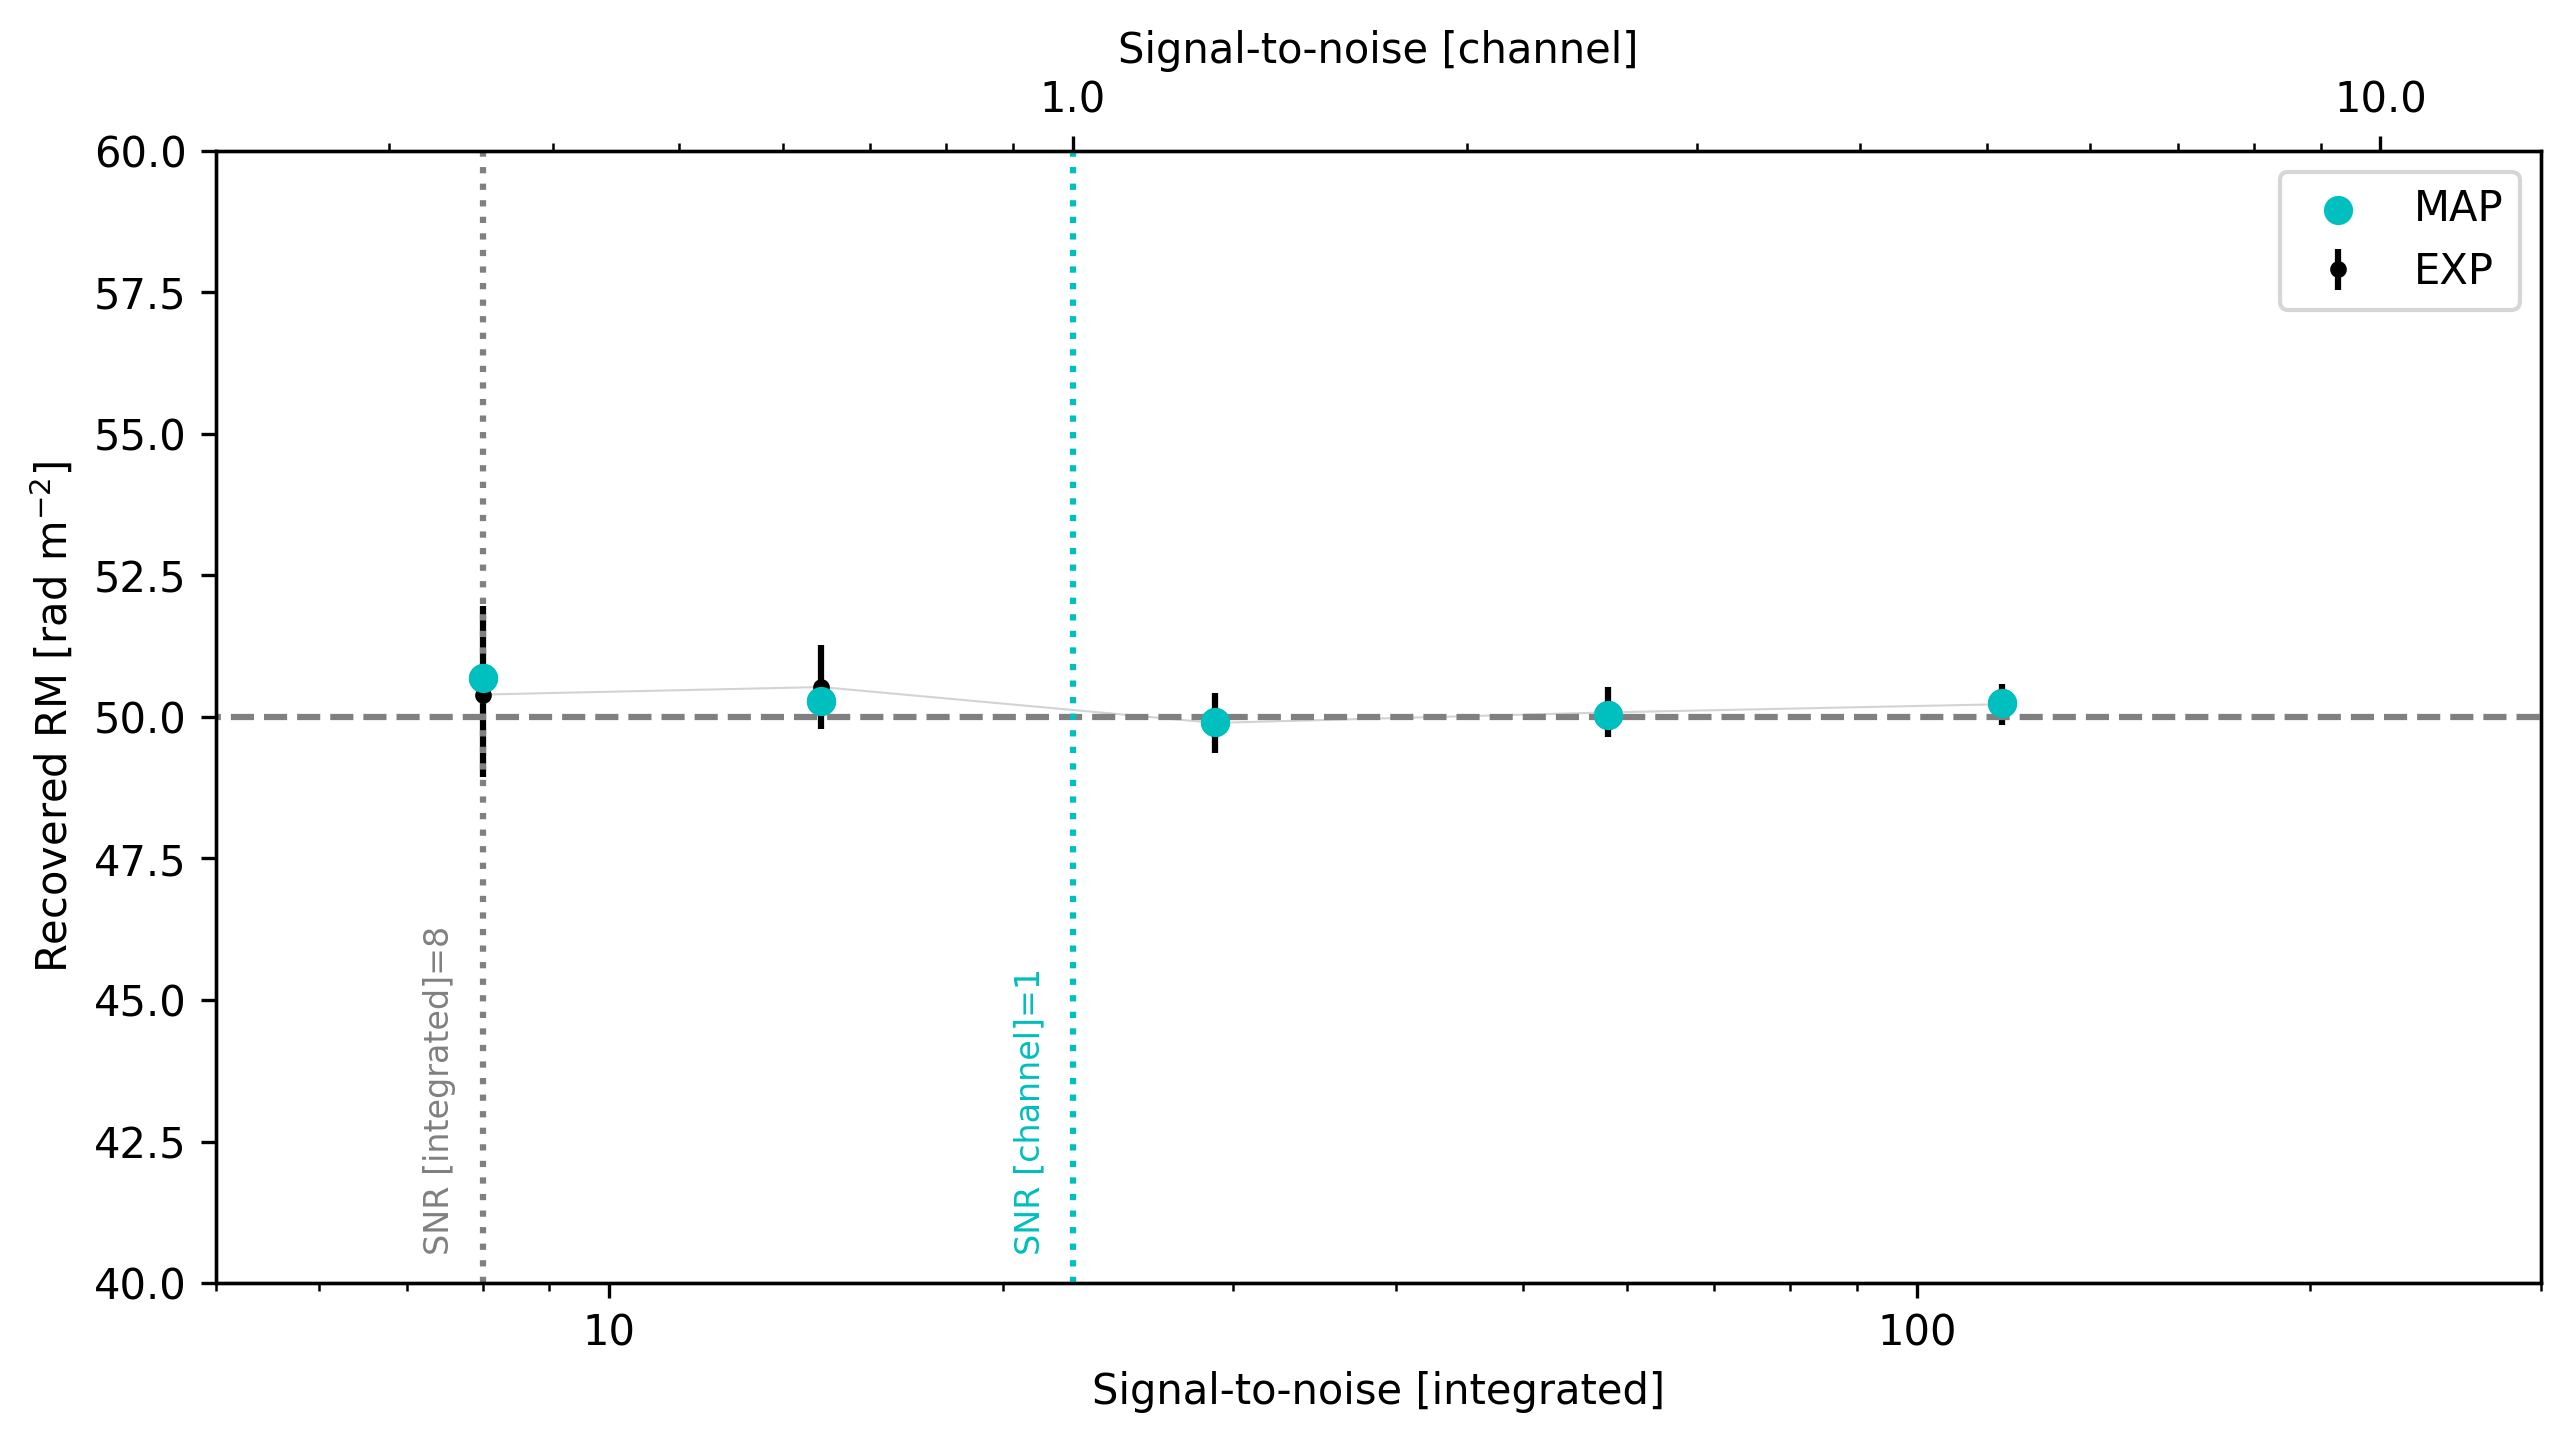

In [11]:
snr_ch = p0/np.array(noise)          # SNR per channel
snr = np.sqrt(len(stokesQ))*snr_ch   # SNR in integrated image

ax = pl.subplot(111)

# plot realisations of EXP values:
for n in range(nreal):
    ax.plot(snr,exps[n,:],ls='-',lw=0.5,c='lightgrey')
    
# plot ML values from final realisation:
ax.scatter(snr,mls,marker='o',c='c',label="MAP")

# plot EXP values from final realisation:
ax.errorbar(snr,exs,yerr=asym_errors,fmt='.',color='black',label="EXP")

# plot true value:
ax.plot([0,300],[50.,50.],ls='--',c='grey')

# 8 sigma integrated flux:
ax.plot([8,8],[40.,60.],ls=':',c='grey')
ax.text(7.2, 40.5, 'SNR [integrated]=8', color='grey', fontsize=8, rotation=90, verticalalignment='bottom')

# plot axis with channel SNRs:
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(snr_ch,mls,marker='o',c='c')

# plot 1 sigma channel flux:
ax2.plot([1,1],[40.,60.],ls=':',c='c')
ax2.text(0.9, 40.5, 'SNR [channel]=1', color='c', fontsize=8, rotation=90, verticalalignment='bottom')

# plot labels:
ax.set_xlabel("Signal-to-noise [integrated]")
ax2.set_xlabel("Signal-to-noise [channel]")  # we already handled the x-label with ax1
ax.set_ylabel(r"Recovered RM [rad m$^{-2}$]")

# format axes:
ax.axis([5.,300.,40.,60.])
ax2.axis([5./np.sqrt(len(stokesQ)),300./np.sqrt(len(stokesQ)),40.,60.])
ax.semilogx()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax2.semilogx()
ax2.xaxis.set_major_formatter(ScalarFormatter())

# add legend:
ax.legend()

# display plot:
pl.show()

Now run multiple realisations for illustration:

In [12]:
nreal = 10    # takes ~4 mins per realisation on MacBook Pro

In [13]:
exps = np.zeros((nreal,noise.shape[0]))  # array to store expectation values for each realisation

for n in tqdm_notebook(range(nreal)):
    mls,exs,asym_errors = runreal(l2, stokesQ, stokesU,  noise)
    exps[n,:] = exs

---
### Make plot

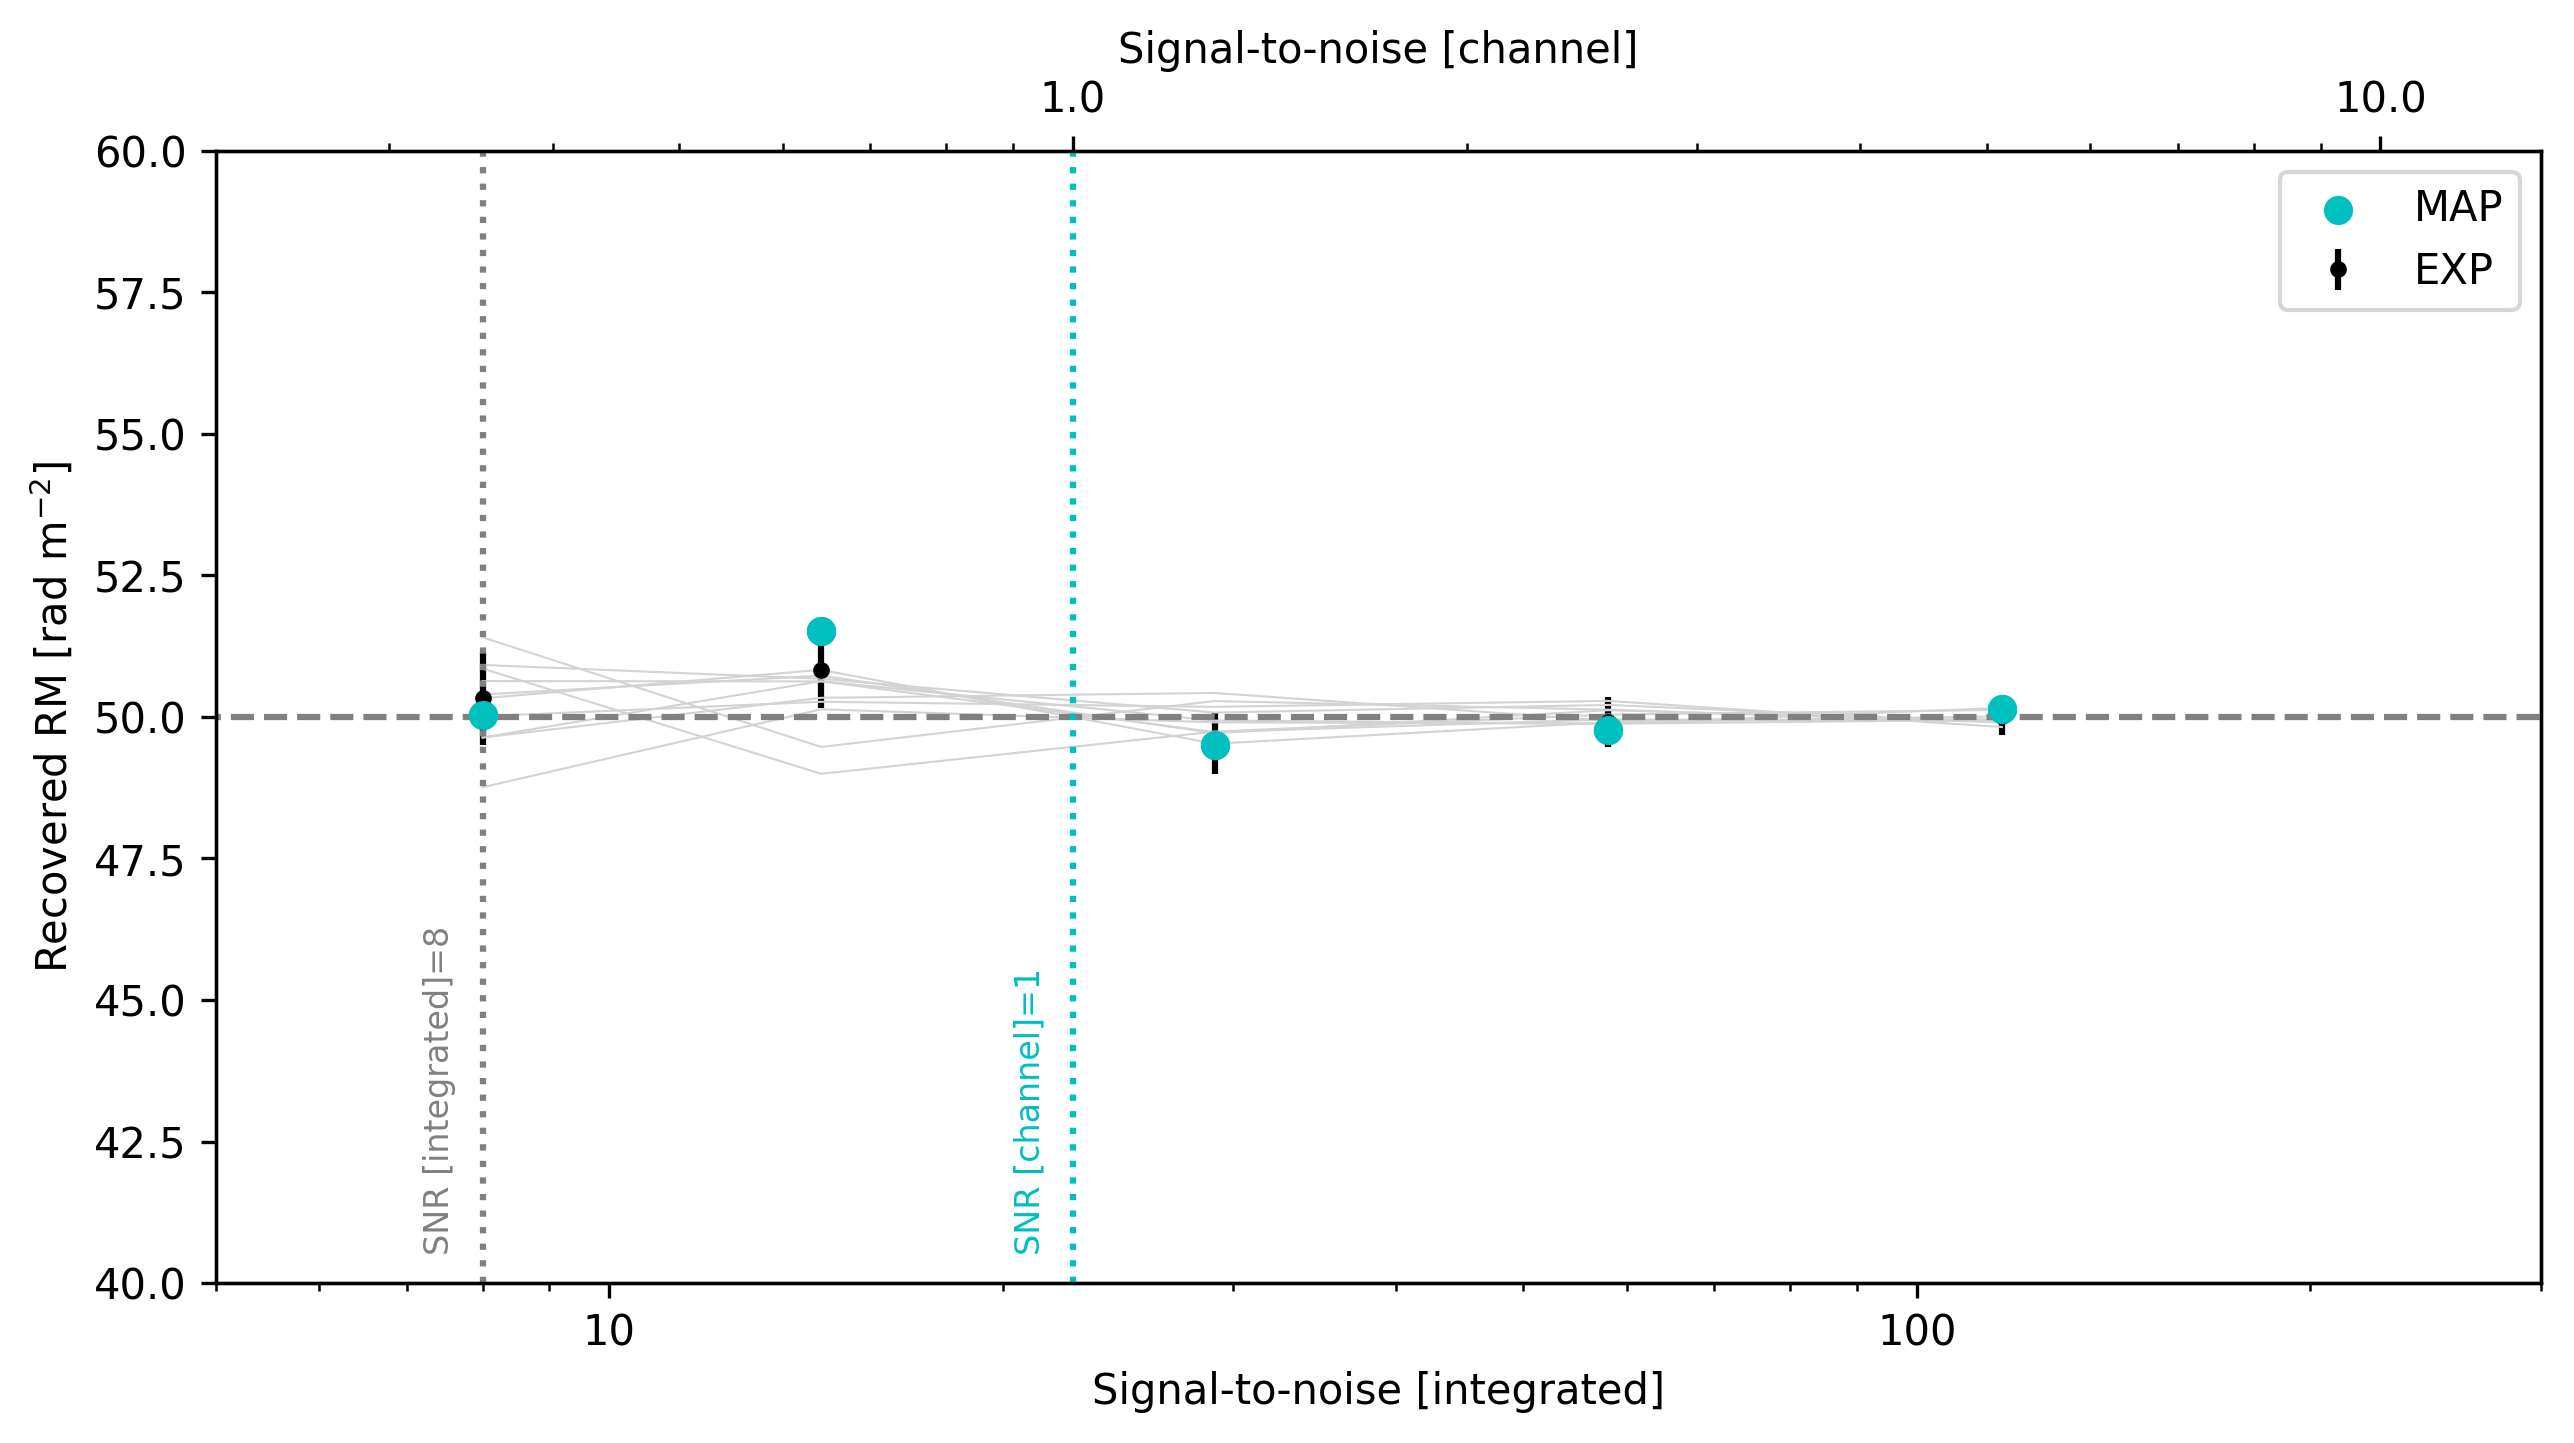

In [14]:
snr_ch = p0/np.array(noise)          # SNR per channel
snr = np.sqrt(len(stokesQ))*snr_ch   # SNR in integrated image

ax = pl.subplot(111)

# plot realisations of EXP values:
for n in range(nreal):
    ax.plot(snr,exps[n,:],ls='-',lw=0.5,c='lightgrey')
    
# plot ML values from final realisation:
ax.scatter(snr,mls,marker='o',c='c',label="MAP")

# plot EXP values from final realisation:
ax.errorbar(snr,exs,yerr=asym_errors,fmt='.',color='black',label="EXP")

# plot true value:
ax.plot([0,300],[50.,50.],ls='--',c='grey')

# 8 sigma integrated flux:
ax.plot([8,8],[40.,60.],ls=':',c='grey')
ax.text(7.2, 40.5, 'SNR [integrated]=8', color='grey', fontsize=8, rotation=90, verticalalignment='bottom')

# plot axis with channel SNRs:
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(snr_ch,mls,marker='o',c='c')

# plot 1 sigma channel flux:
ax2.plot([1,1],[40.,60.],ls=':',c='c')
ax2.text(0.9, 40.5, 'SNR [channel]=1', color='c', fontsize=8, rotation=90, verticalalignment='bottom')

# plot labels:
ax.set_xlabel("Signal-to-noise [integrated]")
ax2.set_xlabel("Signal-to-noise [channel]")  # we already handled the x-label with ax1
ax.set_ylabel(r"Recovered RM [rad m$^{-2}$]")

# format axes:
ax.axis([5.,300.,40.,60.])
ax2.axis([5./np.sqrt(len(stokesQ)),300./np.sqrt(len(stokesQ)),40.,60.])
ax.semilogx()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax2.semilogx()
ax2.xaxis.set_major_formatter(ScalarFormatter())

# add legend:
ax.legend()

# display plot:
pl.show()